[Reference](https://medium.com/unit8-machine-learning-publication/time-series-forecasting-using-past-and-future-external-data-with-darts-1f0539585993)

In [1]:
pip install darts

     |████████████████████████████████| 286 kB 5.3 MB/s 
     |████████████████████████████████| 38.2 MB 25 kB/s 
     |████████████████████████████████| 62 kB 837 kB/s 
     |████████████████████████████████| 177 kB 55.0 MB/s 
     |████████████████████████████████| 11.2 MB 31.0 MB/s 
     |████████████████████████████████| 9.8 MB 50.1 MB/s 
     |████████████████████████████████| 790 kB 44.5 MB/s 
     |████████████████████████████████| 2.0 MB 44.4 MB/s 
     |████████████████████████████████| 11.3 MB 39.0 MB/s 
     |████████████████████████████████| 65 kB 4.1 MB/s 
     |████████████████████████████████| 1.4 MB 8.7 kB/s 
     |████████████████████████████████| 155 kB 53.4 MB/s 
     |████████████████████████████████| 374 kB 56.4 MB/s 
     |████████████████████████████████| 873 kB 48.7 MB/s 
     |████████████████████████████████| 49 kB 6.0 MB/s 
     |████████████████████████████████| 214 kB 57.5 MB/s 
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110

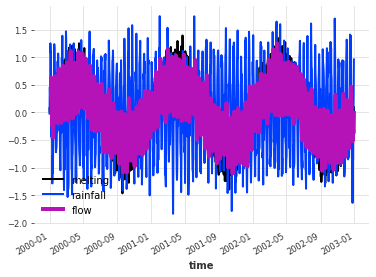

In [1]:
# First, some imports:
import numpy as np
from darts.utils import timeseries_generation as tg

np.random.seed(42)

LENGTH = 3 * 365  # 3 years of daily data

# Melting: a sine with yearly periodicity and additive white noise
melting = (tg.sine_timeseries(length=LENGTH, 
                              value_frequency=(1/365), 
                              freq='D', 
                              column_name='melting')
           + 0.15 * tg.gaussian_timeseries(length=LENGTH, freq='D'))

# Rainfalls: a sine with bi-weekly periodicity and additive white noise
rainfalls = (tg.sine_timeseries(length=LENGTH, 
                                value_frequency=(1/14), 
                                freq='D', 
                                column_name='rainfall')
             + 0.3 * tg.gaussian_timeseries(length=LENGTH, freq='D'))

# We scale and shift the melting by 5 days; giving us the melting contribution
melting_contribution = 0.5 * melting.shift(5)

# We compute similar contribution from the rainfalls
all_contributions = [melting_contribution] + [0.1 * rainfalls.shift(lag) for lag in range(5)]

# We compute the final flow as the sum of everything,
# trimming series so they all have the same start time
flow = sum([series[melting_contribution.start_time():][:melting.end_time()]
            for series in all_contributions]).with_columns_renamed('melting', 'flow')

# add some white noise
flow += 0.1 * tg.gaussian_timeseries(length=len(flow))

melting.plot()
rainfalls.plot()
flow.plot(lw=4)

# Evaluating Models


In [2]:
from darts.metrics import rmse

# We first set aside the first 80% as training series:
flow_train, _ = flow.split_before(0.8)

def eval_model(model, past_covariates=None, future_covariates=None):
    # Past and future covariates are optional because they won't always be used in our tests
    
    # We backtest the model on the last 20% of the flow series, with a horizon of 10 steps:
    backtest = model.historical_forecasts(series=flow, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=0.8, 
                                          retrain=False,
                                          verbose=True, 
                                          forecast_horizon=10)
    
    flow[-len(backtest)-100:].plot()
    backtest.plot(label='backtest (n=10)')
    print('Backtest RMSE = {}'.format(rmse(flow, backtest)))

# First Model: No Covariate


[2021-11-16 12:26:02,364] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 832 samples.
[2021-11-16 12:26:02,364] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 832 samples.
[2021-11-16 12:26:02,423] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-11-16 12:26:02,423] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
  1%|          | 1/100 [00:00<00:50,  1.95it/s]

 11%|█         | 11/100 [00:02<00:22,  4.04it/s]

 21%|██        | 21/100 [00:05<00:19,  4.06it/s]

 31%|███       | 31/100 [00:07<00:16,  4.09it/s]

 41%|████      | 41/100 [00:10<00:14,  4.10it/s]

 51%|█████     | 51/100 [00:12<00:11,  4.11it/s]

 61%|██████    | 61/100 [00:15<00:09,  4.01it/s]

 71%|███████   | 71/100 [00:17<00:07,  4.12it/s]

 81%|████████  | 81/100 [00:20<00:04,  4.14it/s]

 91%|█████████ | 91/100 [00:22<00:02,  4.04it/s]

100%|██████████| 210/210 [00:02<00:00, 104.92it/s]


Backtest RMSE = 0.1713621993431753


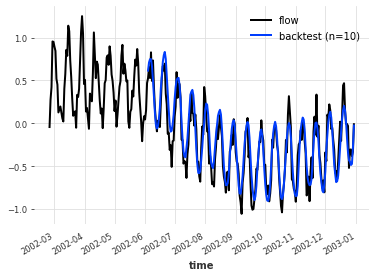

In [3]:
from darts.models import BlockRNNModel

brnn_no_cov = BlockRNNModel(input_chunk_length=30, 
                            output_chunk_length=10, 
                            n_rnn_layers=2)

brnn_no_cov.fit(flow_train, 
                epochs=100, 
                verbose=True)

eval_model(brnn_no_cov)

# Second Model: Using Past Melting Data


[2021-11-16 12:26:29,806] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 832 samples.
[2021-11-16 12:26:29,806] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 832 samples.
[2021-11-16 12:26:29,818] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-11-16 12:26:29,818] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
  1%|          | 1/100 [00:00<00:43,  2.28it/s]

 11%|█         | 11/100 [00:04<00:39,  2.26it/s]

 21%|██        | 21/100 [00:09<00:35,  2.25it/s]

 31%|███       | 31/100 [00:13<00:30,  2.28it/s]

 41%|████      | 41/100 [00:18<00:25,  2.30it/s]

 51%|█████     | 51/100 [00:22<00:22,  2.22it/s]

 61%|██████    | 61/100 [00:27<00:17,  2.29it/s]

 71%|███████   | 71/100 [00:31<00:12,  2.26it/s]

 81%|████████  | 81/100 [00:35<00:08,  2.28it/s]

 91%|█████████ | 91/100 [00:40<00:04,  2.24it/s]

100%|██████████| 210/210 [00:02<00:00, 95.86it/s]


Backtest RMSE = 0.15348066346573264


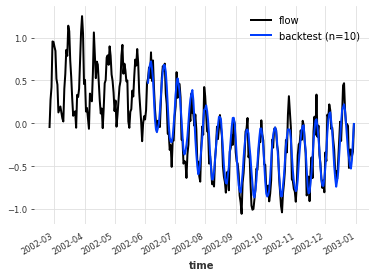

In [4]:
brnn_melting = BlockRNNModel(input_chunk_length=30, 
                             output_chunk_length=10, 
                             n_rnn_layers=2)

brnn_melting.fit(flow_train, 
                 past_covariates=melting, 
                 epochs=100, 
                 verbose=True)

eval_model(brnn_melting, 
           past_covariates=melting)

# Third Model: Using Past Melting and Past Rainfall Data


[2021-11-16 12:28:27,627] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 832 samples.
[2021-11-16 12:28:27,627] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 832 samples.
[2021-11-16 12:28:27,634] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-11-16 12:28:27,634] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
  1%|          | 1/100 [00:00<00:43,  2.26it/s]

 11%|█         | 11/100 [00:04<00:40,  2.21it/s]

 21%|██        | 21/100 [00:09<00:35,  2.23it/s]

 31%|███       | 31/100 [00:13<00:30,  2.24it/s]

 41%|████      | 41/100 [00:18<00:26,  2.23it/s]

 51%|█████     | 51/100 [00:22<00:22,  2.21it/s]

 61%|██████    | 61/100 [00:27<00:17,  2.22it/s]

 71%|███████   | 71/100 [00:31<00:12,  2.27it/s]

 81%|████████  | 81/100 [00:36<00:08,  2.23it/s]

 91%|█████████ | 91/100 [00:40<00:04,  2.24it/s]

100%|██████████| 210/210 [00:02<00:00, 95.17it/s]


Backtest RMSE = 0.15427816090462906


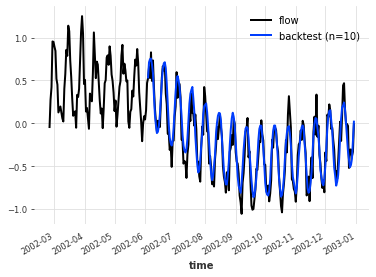

In [5]:
brnn_melting_and_rain = BlockRNNModel(input_chunk_length=30, 
                                      output_chunk_length=10, 
                                      n_rnn_layers=2)

brnn_melting_and_rain.fit(flow_train, 
                          past_covariates=melting.stack(rainfalls), 
                          epochs=100, 
                          verbose=True)

eval_model(brnn_melting_and_rain, 
           past_covariates=melting.stack(rainfalls))

[2021-11-16 12:29:16,279] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 831 samples.
[2021-11-16 12:29:16,279] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 831 samples.
[2021-11-16 12:29:16,289] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-11-16 12:29:16,289] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
  1%|          | 1/100 [00:00<01:19,  1.25it/s]

 11%|█         | 11/100 [00:08<01:07,  1.32it/s]

 21%|██        | 21/100 [00:16<01:00,  1.31it/s]

 31%|███       | 31/100 [00:23<00:52,  1.30it/s]

 41%|████      | 41/100 [00:31<00:45,  1.30it/s]

 51%|█████     | 51/100 [00:38<00:37,  1.31it/s]

 61%|██████    | 61/100 [00:46<00:29,  1.33it/s]

 71%|███████   | 71/100 [00:54<00:21,  1.32it/s]

 81%|████████  | 81/100 [01:01<00:14,  1.30it/s]

 91%|█████████ | 91/100 [01:09<00:06,  1.32it/s]

100%|██████████| 210/210 [00:03<00:00, 53.21it/s]


Backtest RMSE = 0.16388261826327083


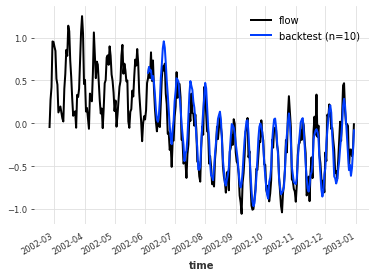

In [6]:
from darts.models import RNNModel

rnn_rain = RNNModel(input_chunk_length=30, 
                    training_length=40, 
                    n_rnn_layers=2)

rnn_rain.fit(flow_train, 
             future_covariates=rainfalls, 
             epochs=100, 
             verbose=True)

eval_model(rnn_rain, 
           future_covariates=rainfalls)

# Fifth Model: Using Past Melting and Future Rainfalls


100%|██████████| 210/210 [00:02<00:00, 101.39it/s]


Backtest RMSE = 0.1017916159438457


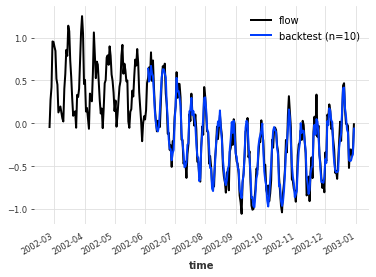

In [7]:
from darts.models import RegressionModel

regr_model = RegressionModel(lags=None,
                             lags_past_covariates=[-5, -4, -3, -2, -1], 
                             lags_future_covariates=[-4, -3, -2, -1, 0])

regr_model.fit(flow_train,
               past_covariates=melting,
               future_covariates=rainfalls)

eval_model(regr_model)